# Import Libraries

In [ ]:
import os
import re
import string
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import numpy as np
import pickle
os.system('pip install -qq transformers')
os.system('pip install -q -U watermark')
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!pip install watermark

In [ ]:
#The %reload_ext magic command is used to reload an extension.
#In this case, it's reloading the watermark extension, which allows you to print information about the environment and packages used in your Jupyter Notebook.

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.35.0



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Loading

In [ ]:
# Pickle is a Python-specific format for serializing and deserializing data. It's commonly used for saving and loading Python objects.
df_train = pd.read_pickle('/content/drive/MyDrive/Marathi language dataset/marathi_train.pkl')
df_test = pd.read_pickle('/content/drive/MyDrive/Marathi language dataset/marathi_test.pkl')
df_valid = pd.read_pickle('/content/drive/MyDrive/Marathi language dataset/marathi_valid.pkl')

# Data analysis

Text(0.5, 0, 'Sentiment')

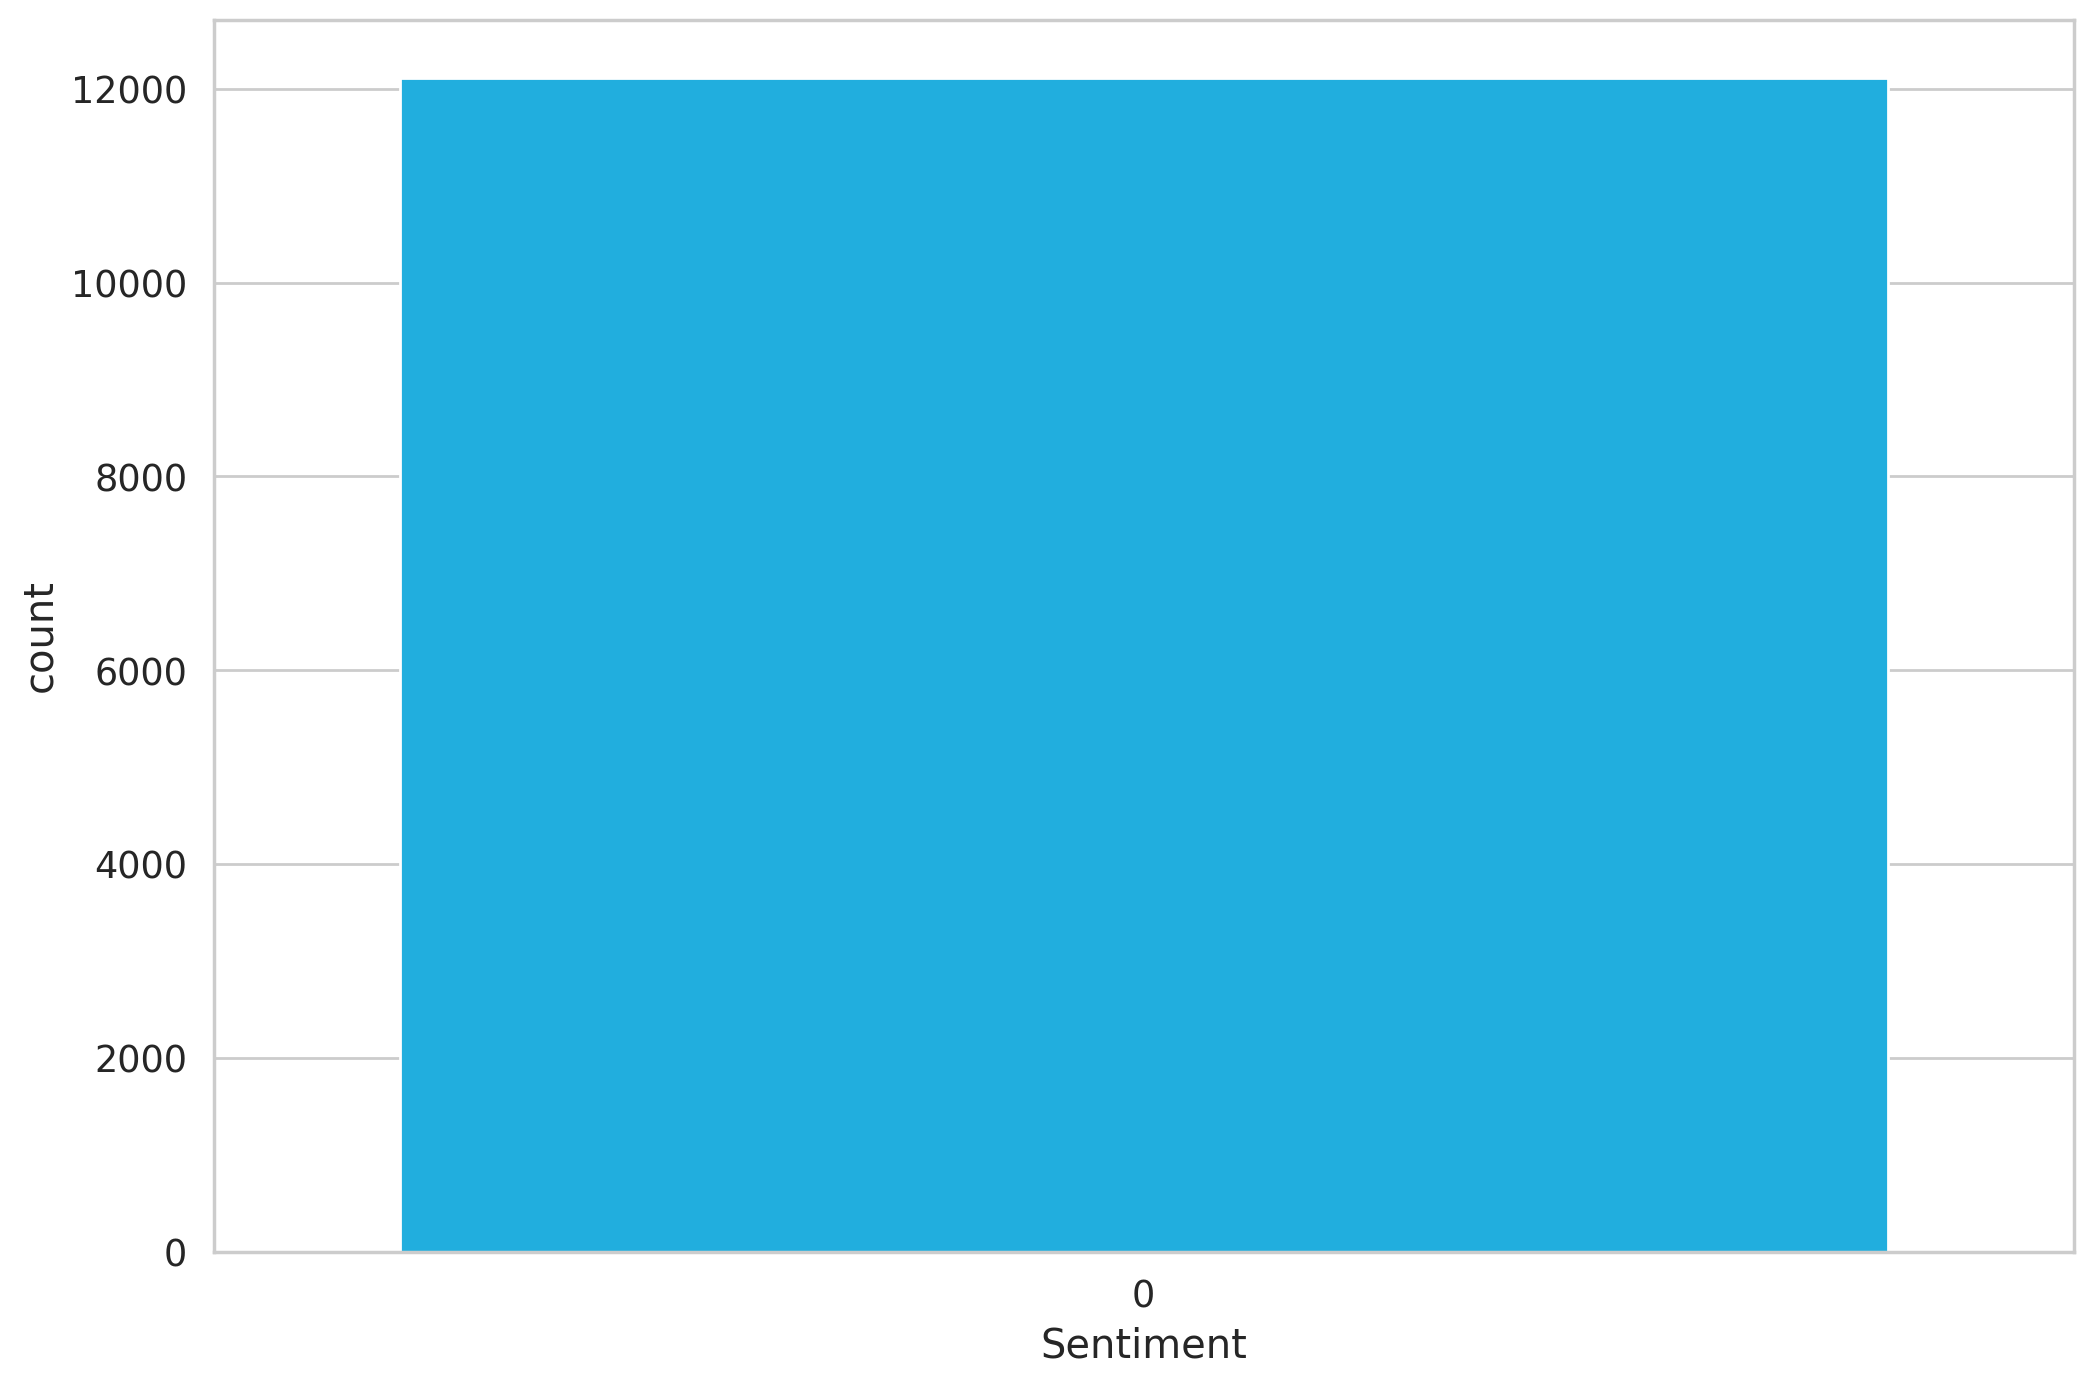

In [ ]:
sns.countplot(df_train.label)
plt.xlabel('Sentiment')

Text(0.5, 0, 'Sentiment')

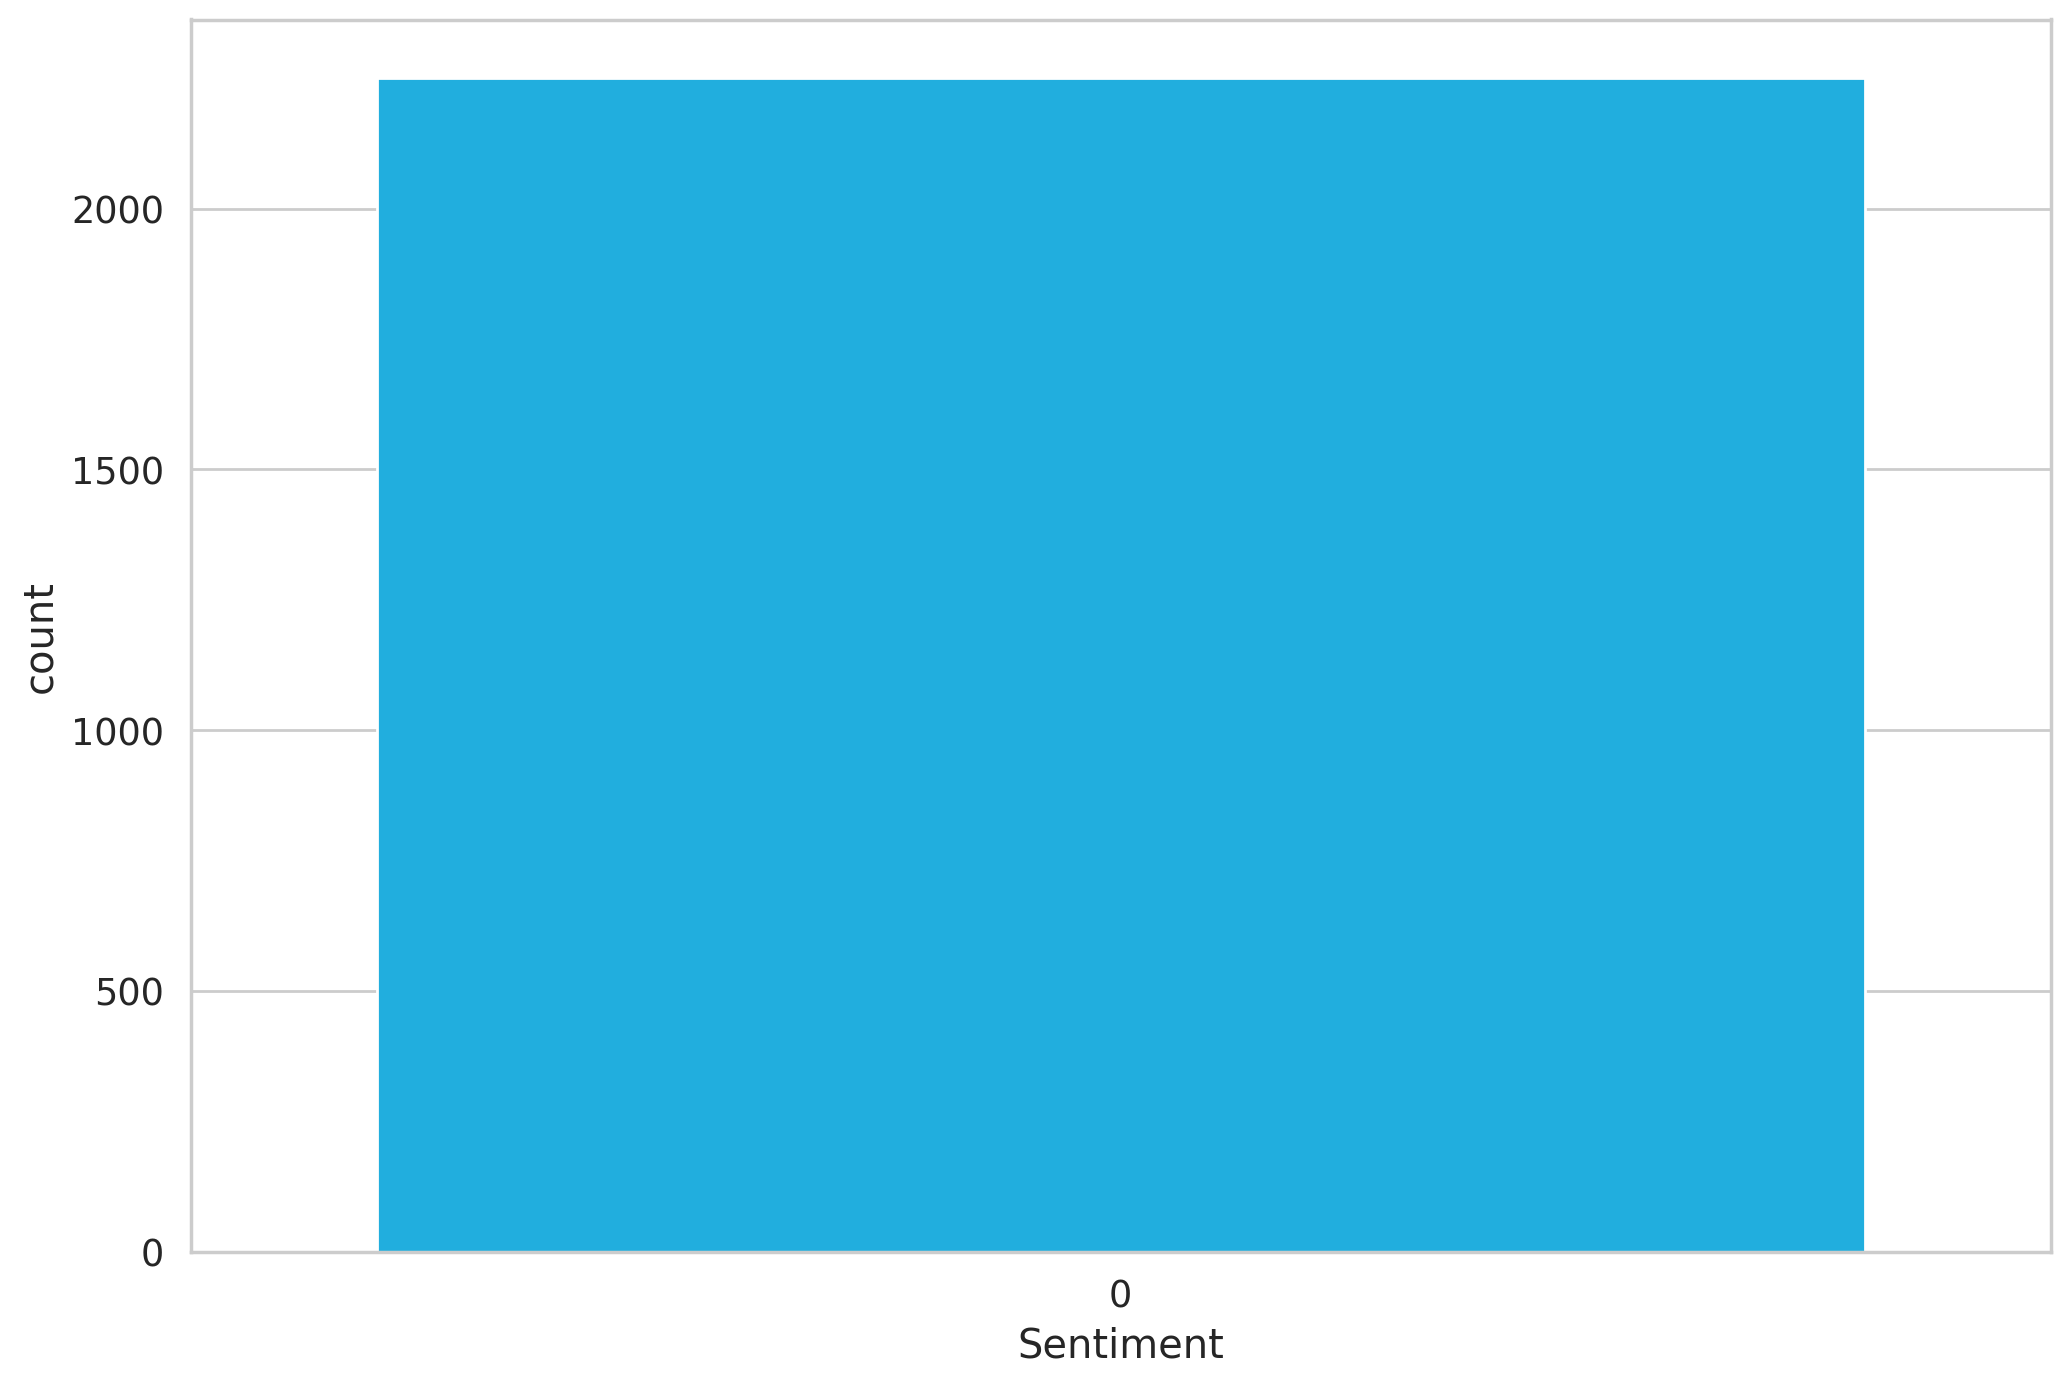

In [ ]:
sns.countplot(df_test.label)
plt.xlabel('Sentiment')

Text(0.5, 0, 'Sentiment')

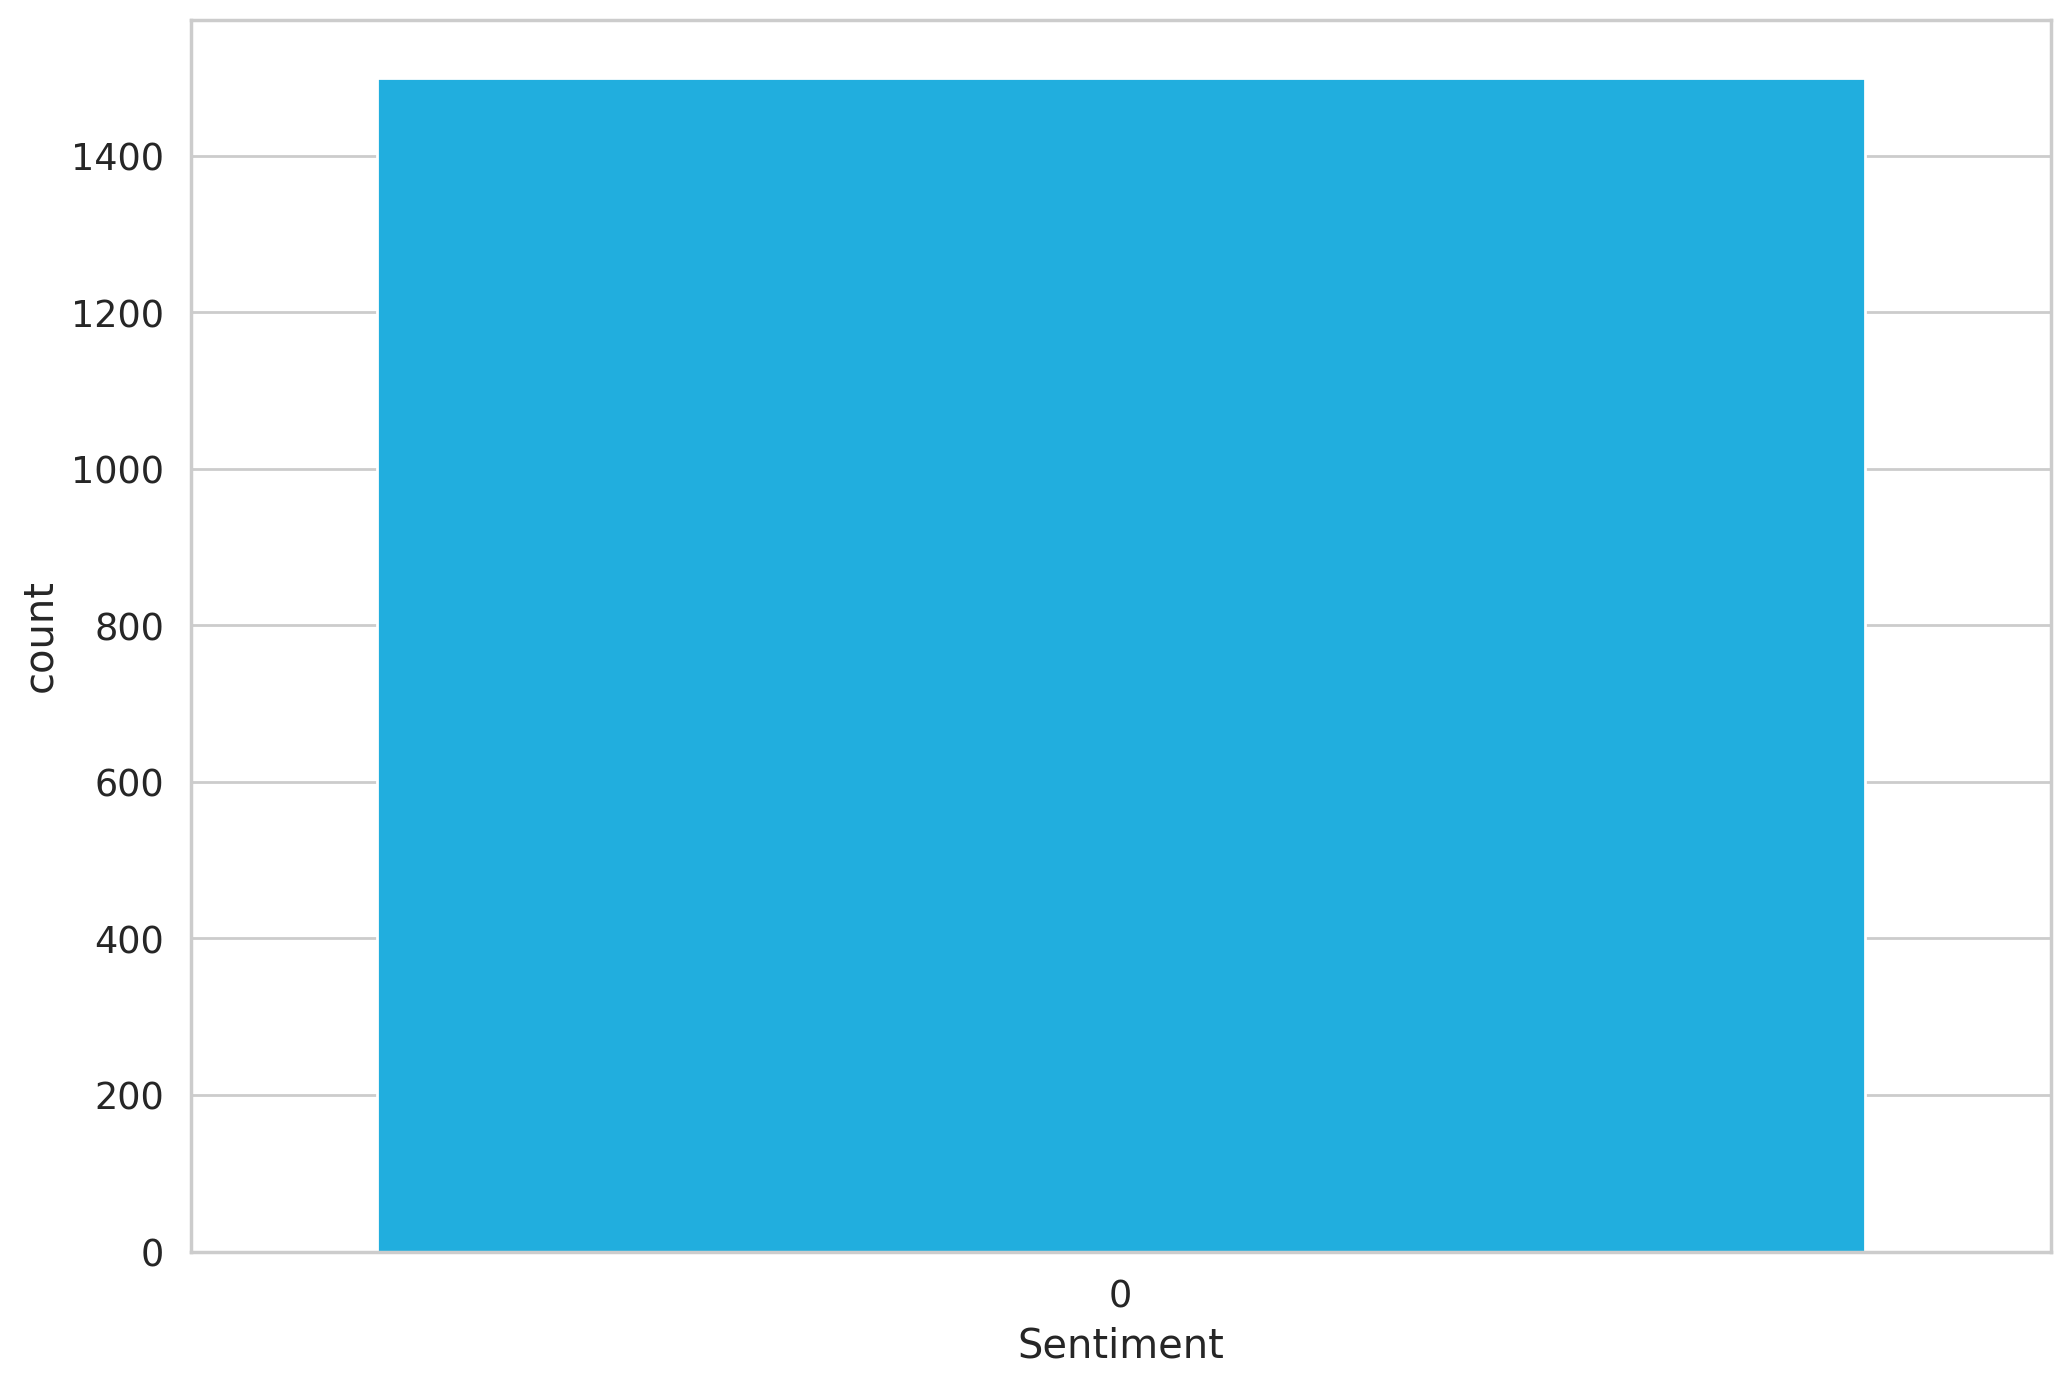

In [ ]:
sns.countplot(df_valid.label)
plt.xlabel('Sentiment')

In [ ]:
# Pandas library to set an option for displaying the maximum column width and then displaying the first 10 rows of training dataset.
pd.set_option("display.max_colwidth", -1)
df_train.head(10)

<ipython-input-8-59429c9b9b2b>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,tweet,label,tuned_tweet
0,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे. चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले. दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली. अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली! \nआम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत. pic.twitter.com/s3gnQQLtpk\n,-1,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली आम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत
1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा. आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे. कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे.\n#AnandTeltumbde\n,-1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे AnandTeltumbde
2,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांचा अवमान व विश्वासघात केला आहे फसवणूक झालेल्या शिवसैनिकांबद्दल मला सहानुभूती असून स्वार्थासाठी उद्धव ठाकरे भाजपसोबत गेले तरी मोदींचे सरकार घालवण्यातच महाराष्ट्राचे हित आहे हे जाणणारे शिवसैनिक मोदींच्या विरोधात काँग्रेसला मतदान करतील\n,-1,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांचा अवमान व विश्वासघात केला आहे फसवणूक झालेल्या शिवसैनिकांबद्दल मला सहानुभूती असून स्वार्थासाठी उद्धव ठाकरे भाजपसोबत गेले तरी मोदींचे सरकार घालवण्यातच महाराष्ट्राचे हित आहे हे जाणणारे शिवसैनिक मोदींच्या विरोधात काँग्रेसला मतदान करतील
3,"आपला समाज खूप मोठा आहे. त्यात अनेक घटक अंतर्भूत आहेत. यातील दिव्यांग हा एक घटक, जो शारीरिकदृष्ट्या कमकुवत आहे, त्याच्याकडे समाजाचे दुर्लक्ष होतेय. त्यामुळे सरकारने अशा व्यक्तींसाठी उपक्रम राबवून त्यांना समाजात सन्मानाने जगता येईल, याकडे लक्ष देण्याची गरज आहे. pic.twitter.com/g0tbJyyTPX\n",1,"आपला समाज खूप मोठा आहे त्यात अनेक घटक अंतर्भूत आहेत यातील दिव्यांग हा एक घटक, जो शारीरिकदृष्ट्या कमकुवत आहे, त्याच्याकडे समाजाचे दुर्लक्ष होतेय त्यामुळे सरकारने अशा व्यक्तींसाठी उपक्रम राबवून त्यांना समाजात सन्मानाने जगता येईल, याकडे लक्ष देण्याची गरज आहे"
4,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म्हणणारे सावरकर आम्हाला मान्य नाहीत. द्वेष आणि तिरस्कार हिंदू धर्मातही अभिप्रेत कधीच नव्हता. आम्ही सावरकरांच्या विचारांचा विरोध करताच राहू त्यात व्यक्तीद्वेष नाही तर वैचारिक विरोध आहे. हा देश गांधींच्या विचारांनीच चालेल!\n,-1,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म्हणणारे सावरकर आम्हाला मान्य नाहीत द्वेष आणि तिरस्कार हिंदू धर्मातही अभिप्रेत कधीच नव्हता आम्ही सावरकरांच्या विचारांचा विरोध करताच राहू त्यात व्यक्तीद्वेष नाही तर वैचारिक विरोध आहे हा देश गांधींच्या विचारांनीच चालेल
5,जरी मी देशाच्या सेवेत मृत्यू पावली तरी मला त्याचा अभिमान वाटेल..माझ्या रक्ताचे प्रत्येक थेंब या राष्ट्राच्या विकासास हातभार लावेल आणि ते मजबूत व गतिमान बनवेल-श्रीमती इंदिरा गांधी\n\nस्वतंत्र भारताच्या पहिल्या महिला पंतप्रधान इंदिरा गांधी यांना विनम्र अभिवादन !\n#IndiraGandhi pic.twitter.com/JDZ3mDqBeO\n,1,जरी मी देशाच्या सेवेत मृत्यू पावली तरी मला त्याचा अभिमान वाटेल माझ्या रक्ताचे प्रत्येक थेंब या राष्ट्राच्या विकासास हातभार लावेल आणि ते मजबूत व गतिमान बनवेल-श्रीमती इंदिरा गांधी स्वतंत्र भारताच्या पहिल्या महिला पंतप्रधान इंदिरा गांधी यांना विनम्र अभिवादन IndiraGandhi
6,"आज, बारामती शहर परिसरात सुरु असणाऱ्या विविध विकास कामांना प्रत्यक्ष भेटी देत कामाचा आढावा घेतला. शहरासह तालुक्यातील कायदा-सुव्यवस्था सुरळीत राखण्यासाठी अवैध व्यवसाय करणाऱ्यांवर कडक कारवाई करण्याचे निर्देश दिले. pic.twitter.com/WJCsuaQ52M\n",1,"आज, बारामती शहर परिसरात सुरु असणाऱ्या विविध विकास कामांना प्रत्यक्ष भेटी देत कामाचा आढावा घेतला शहरासह तालुक्यातील कायदा-सुव्यवस्था सुरळीत राखण्यासाठी अवैध व्यवसाय करणाऱ्यांवर कडक कारवाई करण्याचे निर्देश दिले"
7,@INCMaharashtra च्या माजी अध्यक्ष स्व. प्रभाताई राव यांना जयंतीनिमित्त विनम्र अभिवादन! pic.twitter.com/Ztvgy1nvxt\n,1,च्या माजी अध्यक्ष स्व प्रभाताई राव यांना जयंतीनिमित्त विनम्र अभिवादन
8,"पालखी सोहळ्यात अपघात 

# Preprocessing with transformers

In [ ]:
!pip install sentencepiece

In [ ]:

# BERT (Bidirectional Encoder Representations from Transformers) model
# This is a pre-trained BERT model specifically designed for Indic languages, which includes Marathi. It's trained to work well with Indic scripts and languages.

# PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'
PRE_TRAINED_MODEL_NAME = 'ai4bharat/indic-bert'

In [ ]:
indic_bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले'

In [ ]:


tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



 Sentence: मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले
   Tokens: ['▁मर', '▁आण', '▁सम', 'थ', '▁बस', '▁स', 'थन', 'क', 'वर', '▁लवकर', '▁पह', 'च', 'लय', '▁पण', '▁द', 'पर', 'पर', 'यत', '▁बस', 'च', '▁', 'वट', '▁पह', 'त', '▁बस', 'ल']
Token IDs: [8351, 23514, 9557, 4090, 1209, 1301, 96276, 507, 555, 12942, 39311, 232, 30361, 576, 2155, 6219, 6219, 47615, 1209, 232, 8, 24296, 39311, 229, 1209, 487]


In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 3
[CLS] 2
<pad> 0
<unk> 1


In [ ]:
# By printing encoding.keys(), you can see which attributes are present in the encoding dictionary,
# allowing you to access and use the encoded input for further processing or model input.

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Max no. of tokens
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[    2,  8351, 23514,  9557,  4090,  1209,  1301, 96276,   507,   555,
         12942, 39311,   232, 30361,   576,  2155,  6219,  6219, 47615,  1209,
           232,     8, 24296, 39311,   229,  1209,   487,     3,     0,     0,
             0,     0]])

In [ ]:
print(len(encoding['token_type_ids'][0]))
encoding['token_type_ids']

32


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '▁मर',
 '▁आण',
 '▁सम',
 'थ',
 '▁बस',
 '▁स',
 'थन',
 'क',
 'वर',
 '▁लवकर',
 '▁पह',
 'च',
 'लय',
 '▁पण',
 '▁द',
 'पर',
 'पर',
 'यत',
 '▁बस',
 'च',
 '▁',
 'वट',
 '▁पह',
 'त',
 '▁बस',
 'ल',
 '[SEP]',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
# This code processes a collection of text data from a DataFrame. It uses a tokenizer to break down each text into smaller units called tokens,
# with a maximum limit of 512 tokens per text. The code then records the number of tokens in each text and stores these lengths in a list called token_lens.
token_lens = []
for txt in tqdm(df_train.tuned_tweet):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

100%|██████████| 12109/12109 [00:04<00:00, 2852.38it/s]


<ipython-input-21-f8256fc61210>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


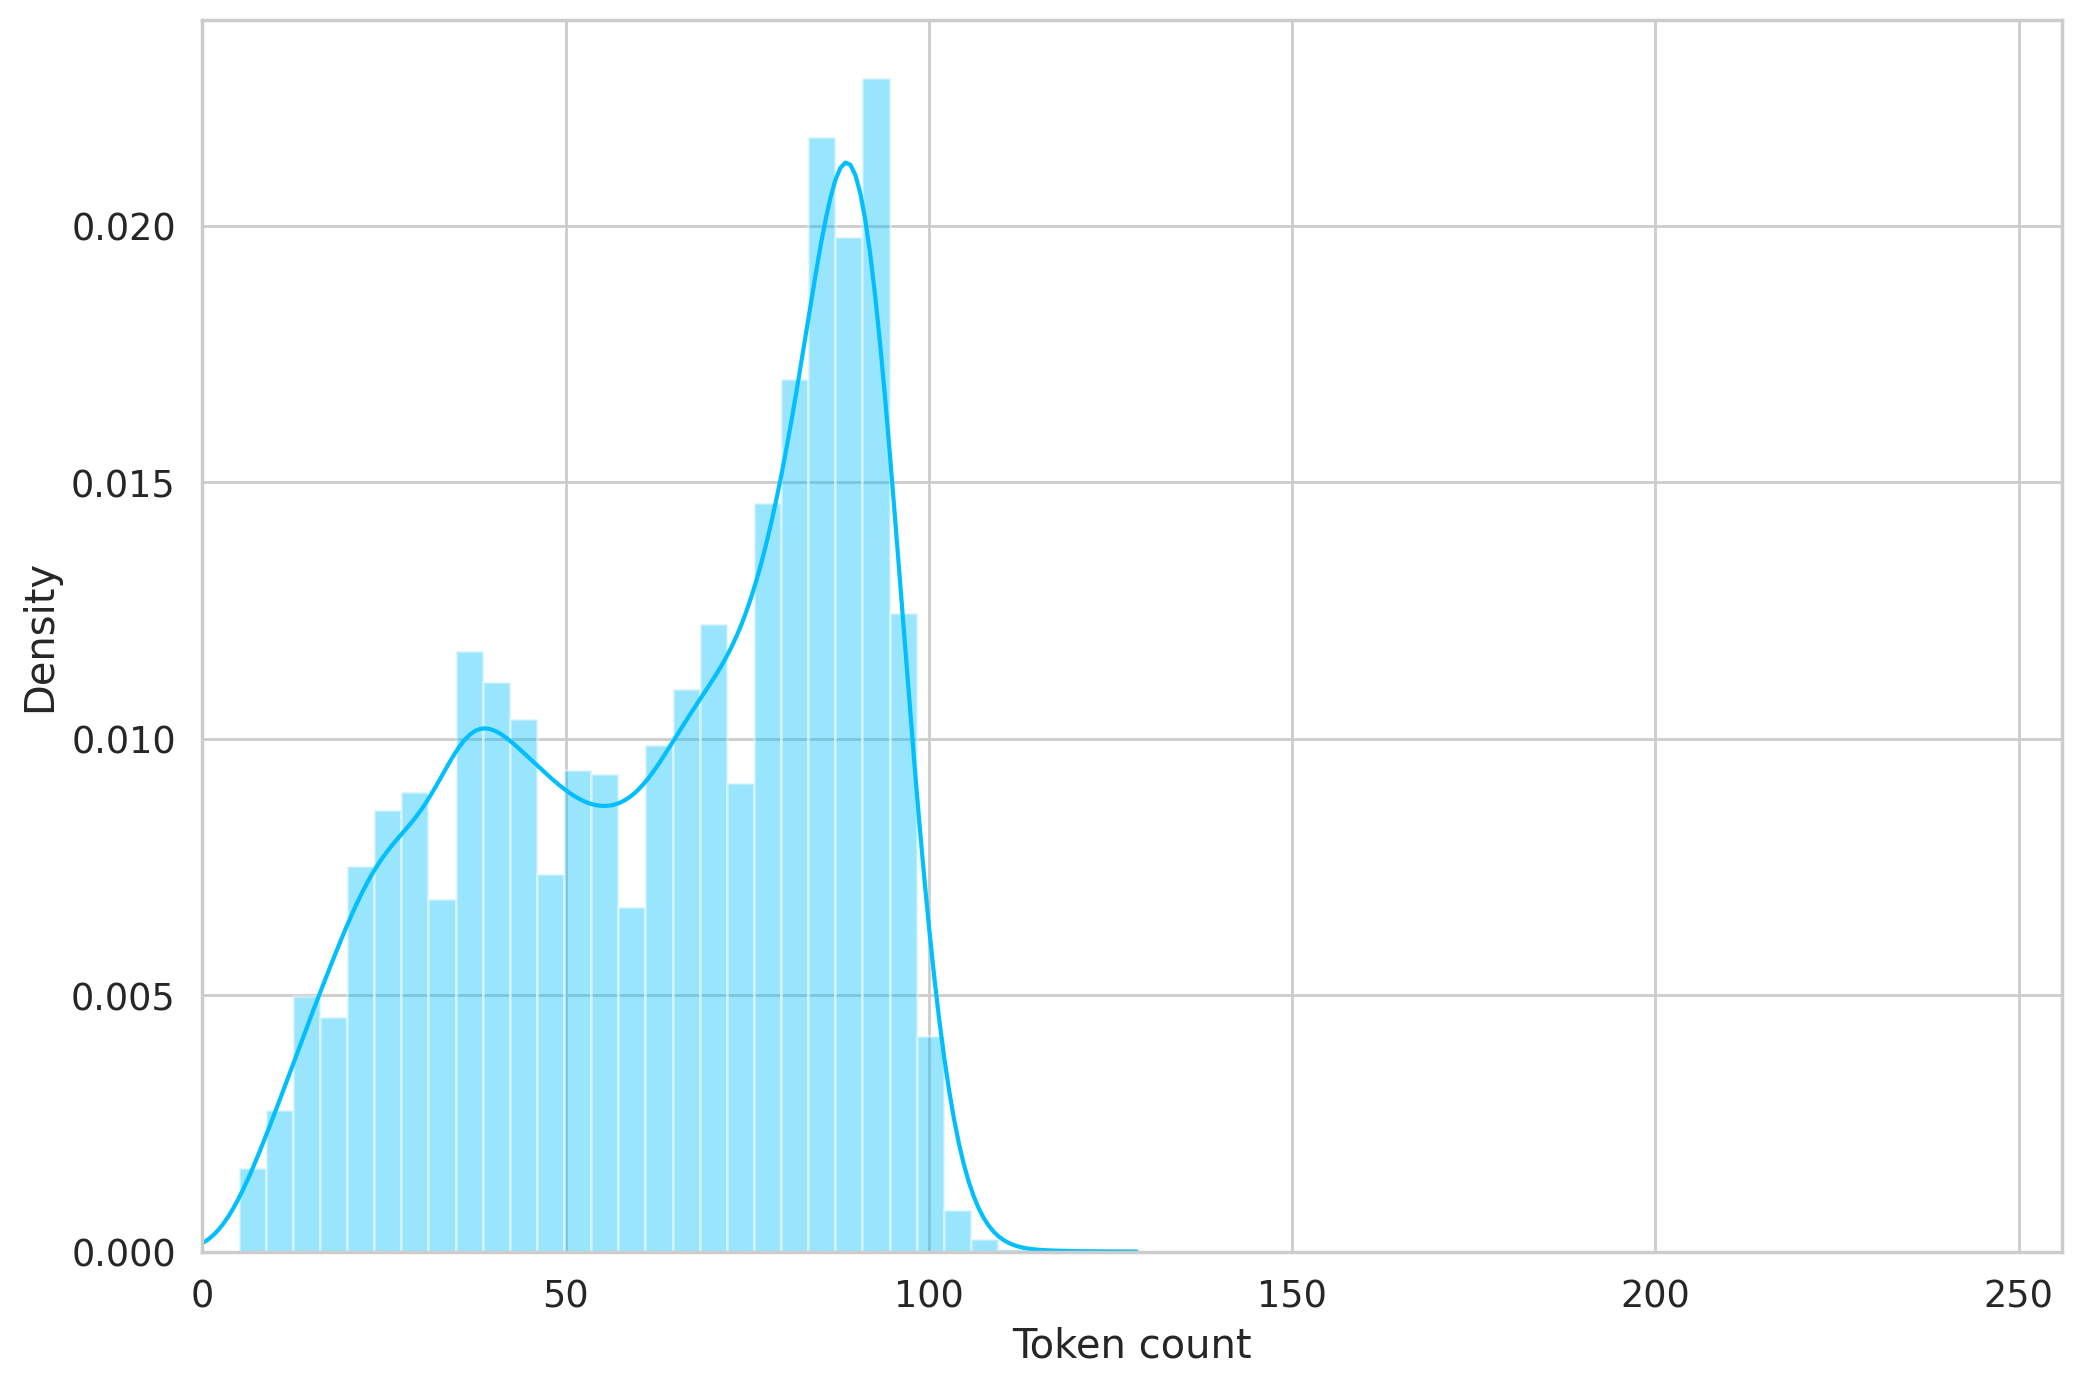

In [ ]:
# you are using the Seaborn library to create a distribution plot (a histogram) of token lengths in your dataset and then displaying it.

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()

In [ ]:
MAX_LEN = 160

In [ ]:
# This custom dataset class is designed to preparetext data for training NLP models, specifically transformer-based models like BERT.
# It encodes the text and organizes it into a format that can be efficiently used for training and evaluation.

class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )

    return {
      'tweet_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_valid.shape, df_test.shape

((12109, 3), (1499, 3), (2250, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.tuned_tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Classification

In [ ]:
print(encoding['attention_mask'] , encoding['token_type_ids'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
x = indic_bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

In [ ]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

torch.Size([1, 32, 768]) torch.Size([1, 768])


In [ ]:
indic_bert_model.config.hidden_size

768

In [ ]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.indic = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150,bidirectional=True,dropout=0.2)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1)
    self.out = nn.Linear(64, n_classes)

  def forward(self, input_ids, attention_mask, token_type_ids):
    x = self.indic(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    pooled_output = x['pooler_output']
    output = self.drop1(pooled_output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

In [ ]:

class_names = ['-1','0', '1']
model = SentimentClassifier(len(class_names), indic_bert_model)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
data

{'tweet_text': ['ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली आम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत',
  'सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे AnandTeltumbde',
  'उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांचा अवमान व विश्वासघात केला आहे फसवणूक झालेल्या शिवसैनिकांबद्दल मला सहानुभूती असून स्वार्थासाठी उद्धव ठाकरे भाजपसोबत गेले तरी मोदींचे सरकार घालवण्यातच महाराष्ट्राचे हित आहे हे जाणणारे शिवसैनिक मोदींच्या विरोधात काँग्रेसला मतदान करतील',
  'आपला समाज खूप मोठा आहे त्यात अनेक घटक अंतर्भूत आहेत यातील दिव्यांग हा एक घटक, जो शारीरिकदृष्ट्या कमकुवत आहे, त्याच्याकडे समाजाचे दुर्लक्ष होतेय त्यामुळे सरकारने अशा व्यक्तींसाठी 

In [ ]:
input_ids

tensor([[     2,   4674,  11611,  ...,      0,      0,      0],
        [     2, 163202,    232,  ...,      0,      0,      0],
        [     2,  27968,  11339,  ...,      0,      0,      0],
        ...,
        [     2,  36159,  44395,  ...,      0,      0,      0],
        [     2,     68,   1325,  ...,      0,      0,      0],
        [     2,      8,      1,  ...,      0,      0,      0]],
       device='cuda:0')

In [ ]:
model(input_ids, attention_mask, token_type_ids)

tensor([[-0.0107, -0.0996, -0.1123],
        [-0.0108, -0.0992, -0.1206],
        [-0.0159, -0.1061, -0.1246],
        [-0.0184, -0.1027, -0.1258],
        [-0.0148, -0.1046, -0.1186],
        [-0.0142, -0.1066, -0.1246],
        [ 0.0004, -0.0894, -0.1273],
        [-0.0215, -0.1062, -0.1197],
        [-0.0122, -0.0987, -0.1163],
        [-0.0109, -0.0908, -0.1227],
        [-0.0212, -0.0985, -0.1212],
        [-0.0136, -0.1065, -0.1252],
        [-0.0197, -0.0999, -0.1204],
        [-0.0194, -0.1004, -0.1211],
        [-0.0213, -0.1011, -0.1214],
        [-0.0206, -0.0992, -0.1224]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.3562, 0.3241, 0.3197],
        [0.3528, 0.3270, 0.3202],
        [0.3552, 0.3268, 0.3180],
        [0.3575, 0.3254, 0.3171],
        [0.3572, 0.3255, 0.3172],
        [0.3588, 0.3240, 0.3171],
        [0.3584, 0.3219, 0.3197],
        [0.3549, 0.3238, 0.3213],
        [0.3580, 0.3238, 0.3182],
        [0.3527, 0.3248, 0.3225],
        [0.3526, 0.3268, 0.3207],
        [0.3543, 0.3270, 0.3187],
        [0.3541, 0.3250, 0.3210],
        [0.3533, 0.3272, 0.3195],
        [0.3542, 0.3281, 0.3177],
        [0.3539, 0.3267, 0.3194]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)
      targets+=1

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids

      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_valid)
  )

  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'indic_bert_bilstm_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------


100%|██████████| 757/757 [04:27<00:00,  2.83it/s]


--> Train loss 1.0073542794904118 accuracy 0.48484598232719467


--> Val   loss 0.8921356074353481 accuracy 0.6164109406270847

Epoch 2/10
----------


100%|██████████| 757/757 [04:26<00:00,  2.84it/s]


--> Train loss 0.8379666960381139 accuracy 0.6570319596993972


--> Val   loss 0.7384671793973192 accuracy 0.7198132088058705

Epoch 3/10
----------


100%|██████████| 757/757 [04:26<00:00,  2.84it/s]


--> Train loss 0.703758890554801 accuracy 0.7389544966553804


--> Val   loss 0.66264201732392 accuracy 0.7424949966644429

Epoch 4/10
----------


100%|██████████| 757/757 [04:28<00:00,  2.82it/s]


--> Train loss 0.6004720736329433 accuracy 0.7861095053266166


--> Val   loss 0.691091794916924 accuracy 0.733822548365577

Epoch 5/10
----------


100%|██████████| 757/757 [04:28<00:00,  2.82it/s]


--> Train loss 0.5282428724644521 accuracy 0.8223635312577422


--> Val   loss 0.6653825274490296 accuracy 0.7505003335557038

Epoch 6/10
----------


100%|██████████| 757/757 [04:28<00:00,  2.82it/s]


--> Train loss 0.46645565205001455 accuracy 0.8494508217028657


--> Val   loss 0.6806605548617688 accuracy 0.7585056704469646

Epoch 7/10
----------


100%|██████████| 757/757 [04:30<00:00,  2.80it/s]


--> Train loss 0.41906310369899125 accuracy 0.86778429267487


--> Val   loss 0.6948978629835109 accuracy 0.762508338892595

Epoch 8/10
----------


100%|██████████| 757/757 [04:28<00:00,  2.82it/s]


--> Train loss 0.3777204362117 accuracy 0.8862829300520275


--> Val   loss 0.7185363127513135 accuracy 0.7611741160773848

Epoch 9/10
----------


100%|██████████| 757/757 [04:28<00:00,  2.82it/s]


--> Train loss 0.33477059067712905 accuracy 0.903955735403419


--> Val   loss 0.7322907372516521 accuracy 0.7645096731154102

Epoch 10/10
----------


100%|██████████| 757/757 [04:28<00:00,  2.81it/s]


--> Train loss 0.314109622536515 accuracy 0.9128747212816913


--> Val   loss 0.7337997707914798 accuracy 0.771847898599066



# Results

In [ ]:
for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu()

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()

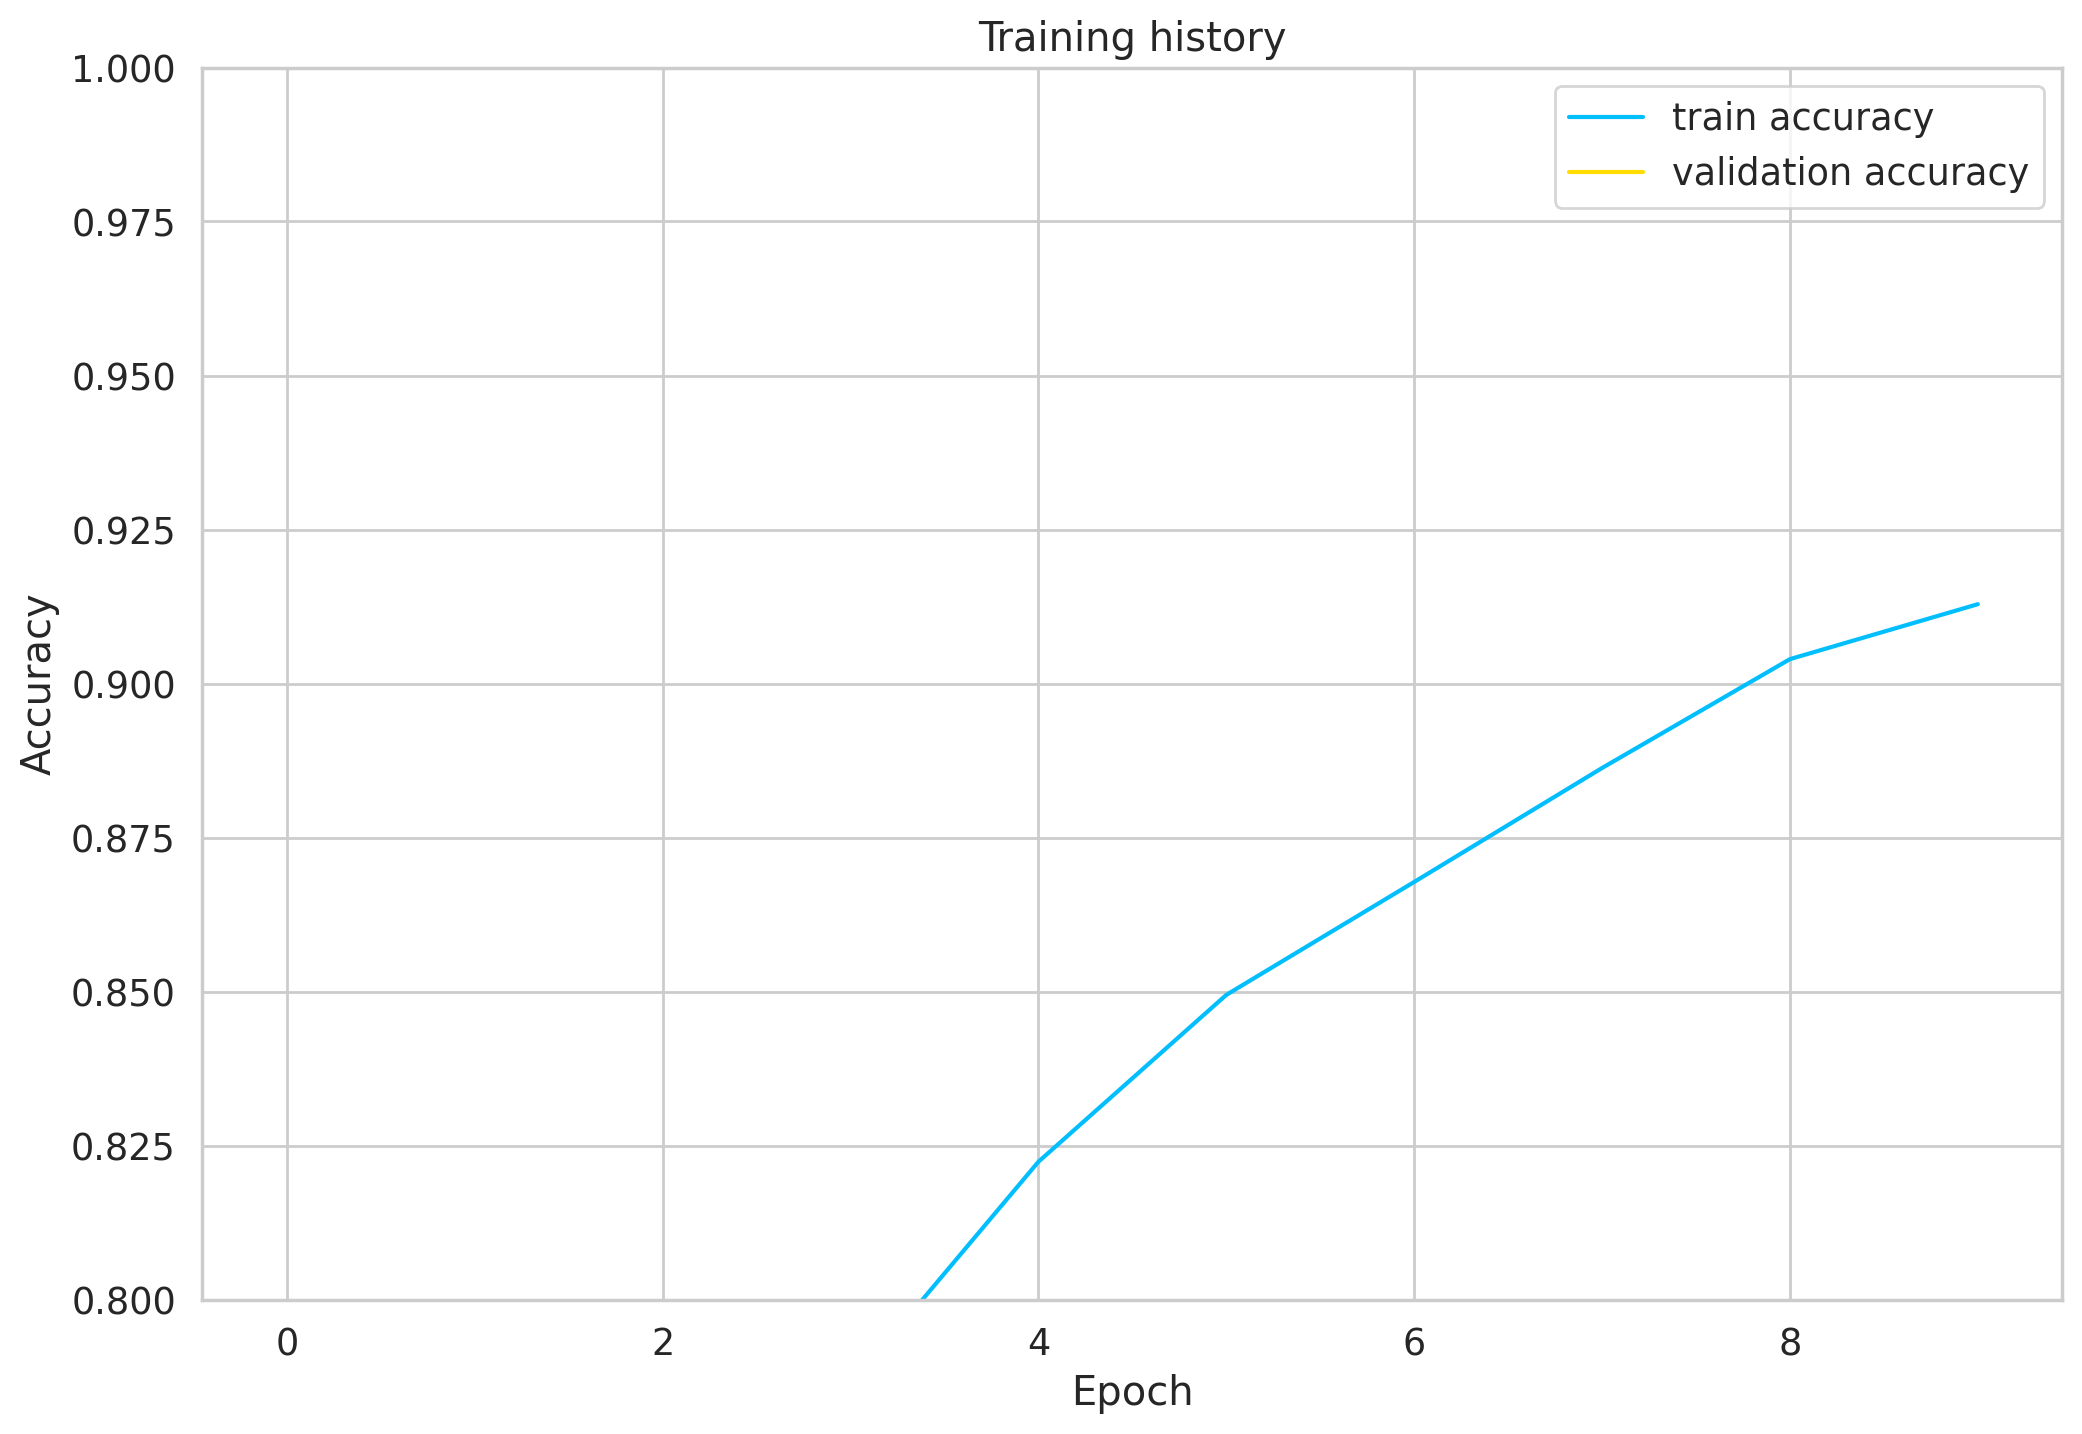

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

# Evaluation

In [ ]:
model2 = SentimentClassifier(len(class_names), indic_bert_model)
model2.load_state_dict(torch.load('indic_bert_bilstm_model_state.bin'))
model2.eval()

SentimentClassifier(
  (indic): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)


In [ ]:
model2 = model2.to(device)

In [ ]:
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7524444444444445

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          -1       0.80      0.81      0.80       750
           0       0.69      0.76      0.72       750
           1       0.77      0.70      0.73       750

    accuracy                           0.75      2250
   macro avg       0.75      0.75      0.75      2250
weighted avg       0.75      0.75      0.75      2250



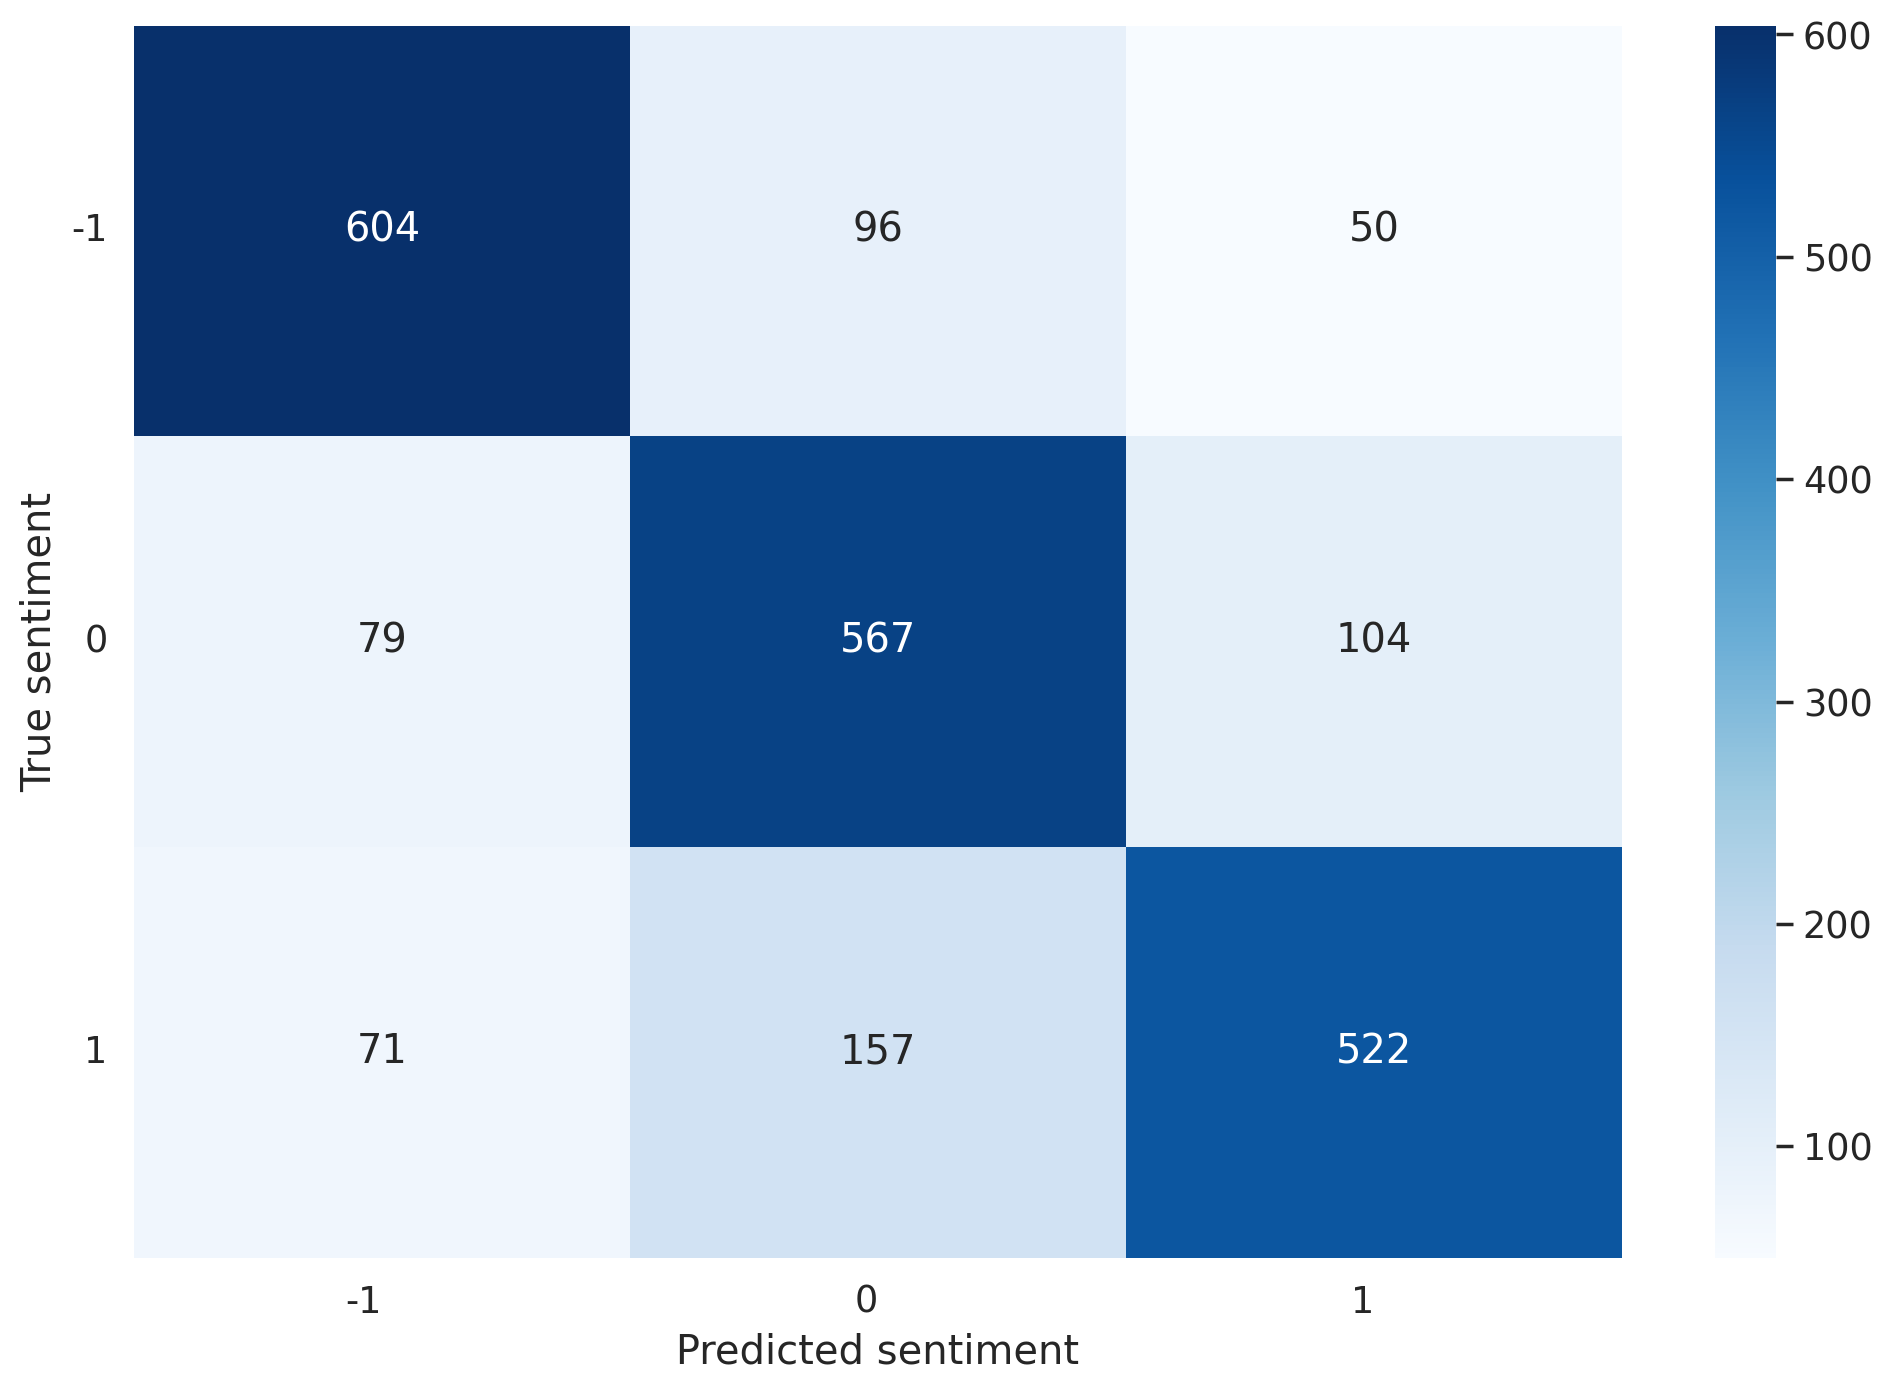

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]

tensor([ 1, -1, -1,  1,  1,  0,  1,  1, -1,  1])

In [ ]:
idx = 50

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})



 आमचे मार्गदर्शक, अहमदनगर शहराचे माजी महापौर व माजी नगराध्यक्ष दीप चव्हाण साहेबांना वाढदिवसाच्या मनःपूर्वक शुभेच्छा 




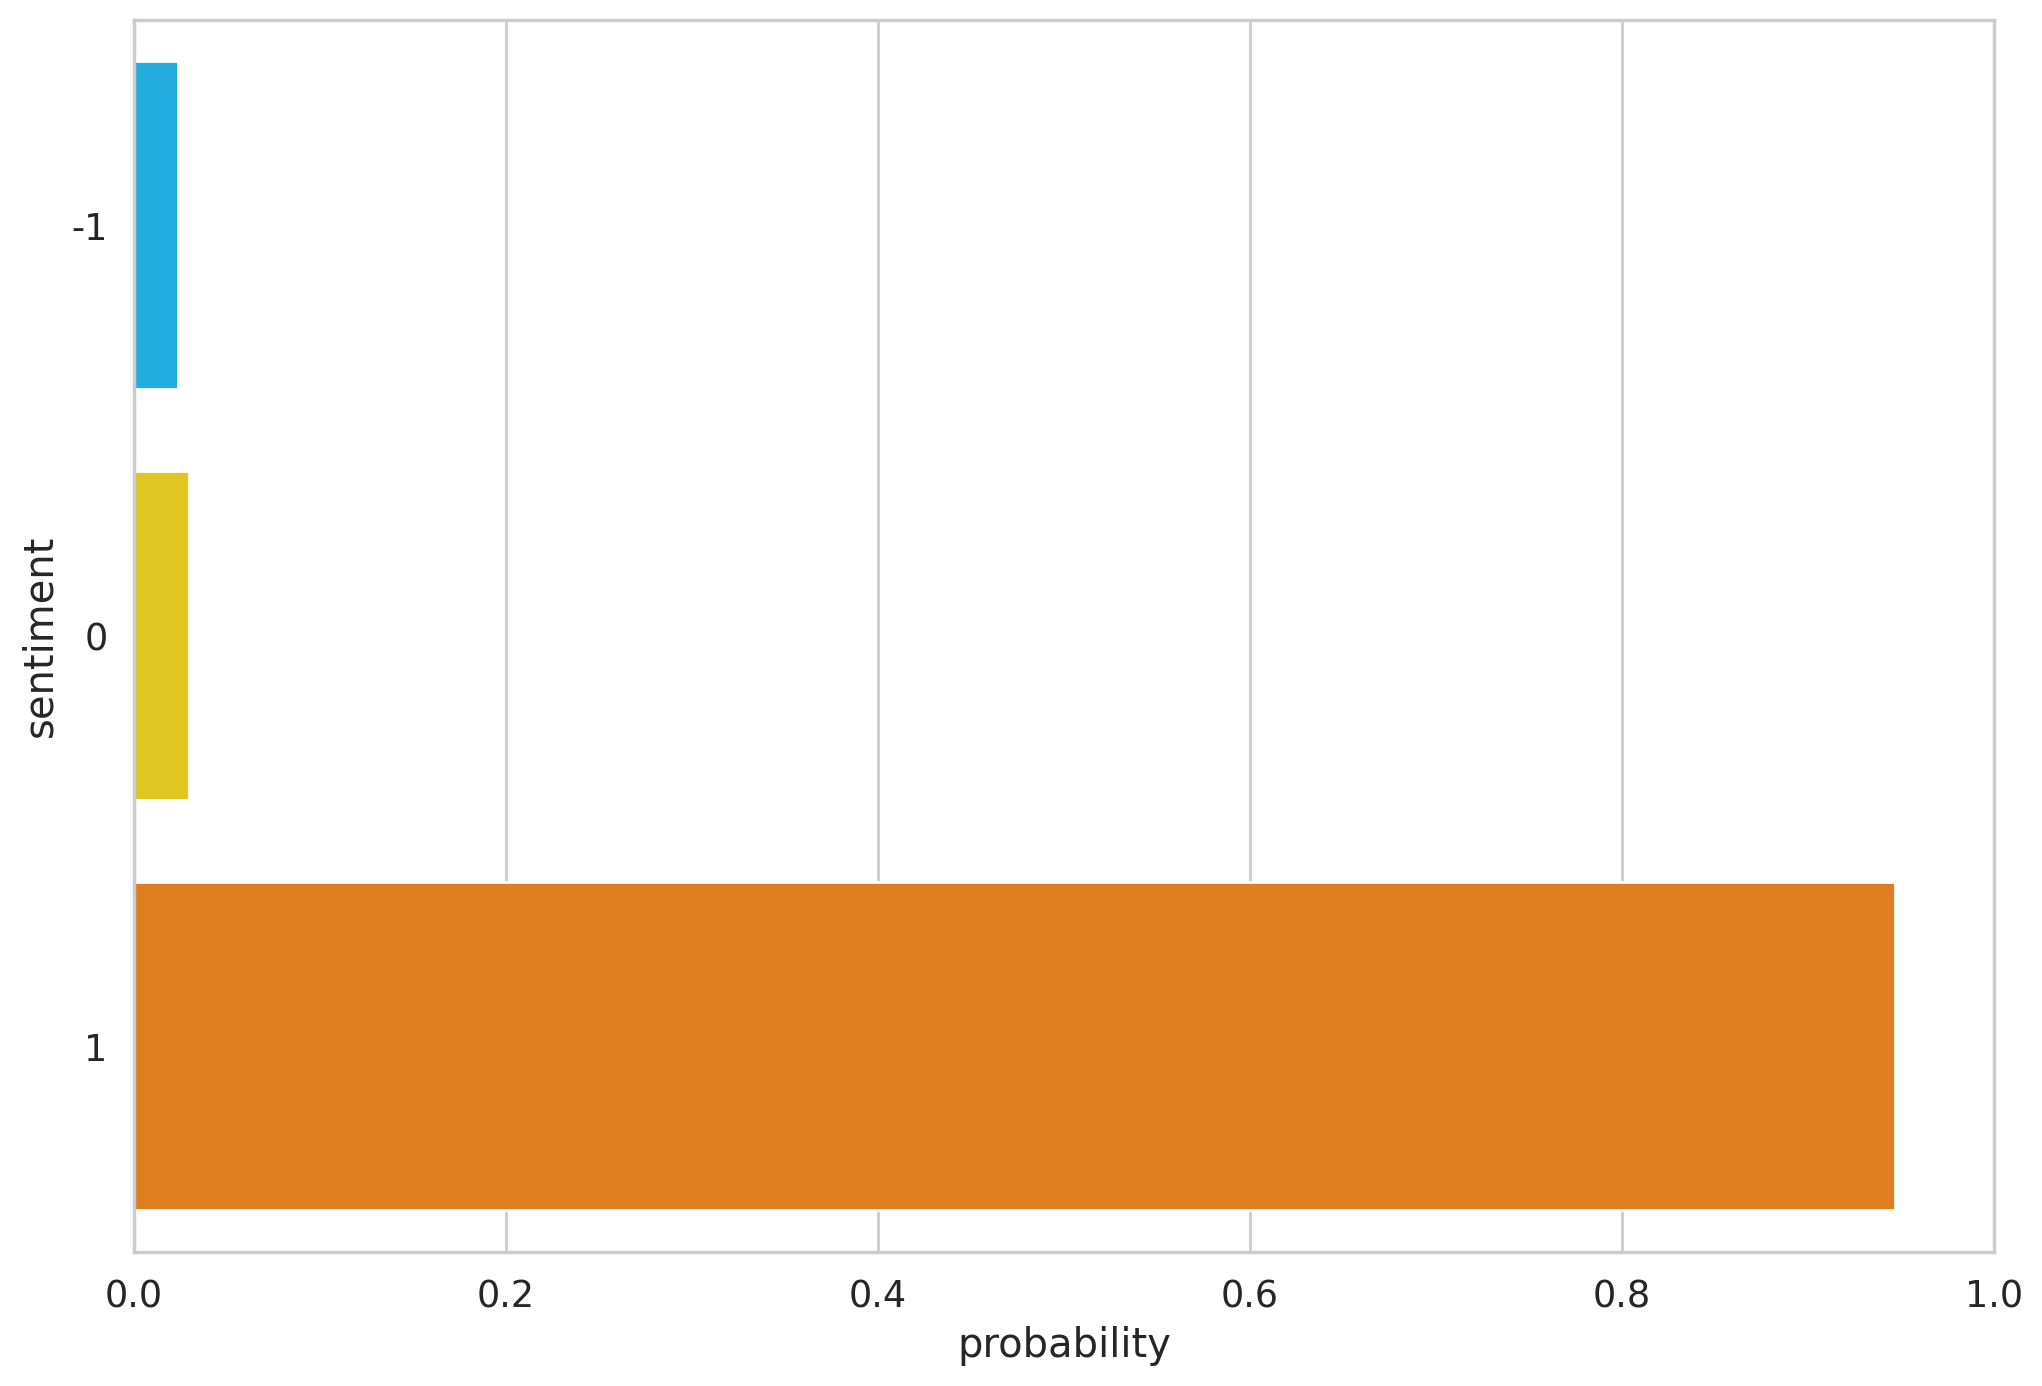

In [ ]:
print('\n\n',tweet_text, '\n\n')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
y_test[14], y_tweet_texts[14]

(tensor(-1),
 'भीमा-पाटस साखर कारखान्याच्या कामगारांना २२ महिन्यांचा पगार मिळाला नाही,मग दौंडच्या आमदारांनी तालुक्यासाठी काय केलं याउलट सूतगिरणी अडचणीत आली,म्हणून आपण टेक्स्टाईल पार्क उभारलं ज्यातून ६००० पेक्षा जास्त महिलांना रोजगार मिळाला या भाजपा-शिवसेनावाल्यांनी बारामतीत कोणता उद्योग आणला')

# Custom Prediction

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()
  line = re.sub(r'\S*\.com\S*'," ",line)
  line = re.sub(r'\S*\.in\S*'," ",line)
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)
  line = re.sub(r'\s+-\s+'," ",line)


  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']

  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens


In [ ]:
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "प्रौढ प्रताप पुरंदर, क्षत्रिय कुलावतंस, सिंहासनाधीश्वर, महाराजाधिराज महाराज श्रीमंत श्री छत्रपती शिवाजी महाराज की जय"
tweet_text = "मनाचे वेधना किती सोसावे सामान्य माणसाने"
tweet_text = "माननीय महोदय संजय विचारे यांच्या अपघाताची बातमी आज कळाली. खूप वाईट वाटले."
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "गढ आला पण माझा सिंह गेला"
tweet_text = "मैदानात हजारो कंडोम पाकीटं कुणी फेकली?; खुलासा होताच अधिकाऱ्यांनी डोक्यावर हात मारला"
tweet_text = "महाशिवरात्रीच्या सर्वांना हार्दिक हार्दिक शुभेच्छा"
tweet_text= "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "हिंदू धर्मात मुलांना लहानपणापासून आपला धर्मग्रंथ गीता शिकवला जात नाही हे सत्य आहे."
tweet_text = "प्रा. यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय."
tweet_text = preprocess(tweet_text)
tweet_text = " ".join(tweet_text)

In [ ]:

encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sarcasm  : {class_names[prediction]}')

Tweet text: प्रा यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय
Sarcasm  : 1
